In [1]:
#from google.colab import drive
#drive.mount('gdrive')

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D, AveragePooling1D, Dropout
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, MaxPooling1D, BatchNormalization, Softmax
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

# Variational Autoencoders (VAEs)

- unsupervised generative model
- latent variable model
- latent variable: cannot be conditioned on for inference because its value is not known
## Autoencoders
- encoders can be viewed as compression algorithms



In [3]:
autoencoder = Sequential([
                          Flatten(input_shape=(28,28)),
                          Dense(256, activation='sigmoid'),
                          Dense(64, activation='sigmoid'),
                          Dense(2, activation='sigmoid'), # bottleneck architecture
                          Dense(64, activation='sigmoid'),
                          Dense(256, activation='sigmoid'),
                          Dense(784, activation='sigmoid'),
                          tf.keras.layers.Reshape((28,28))
])
# input = output so it is unsupervised
autoencoder.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.0005))
#autoencoder.fit(X_train, X_train, epochs=20) # reconstruct input as output through bottleneck (must learn compressed representation)

In [4]:
# separate encoder and decoder
encoder = Sequential([
                      Flatten(input_shape=(28,28)),
                      Dense(256, activation='sigmoid'),
                      Dense(64, activation='sigmoid'),
                      Dense(2, activation='sigmoid')
                      ])

decoder = Sequential([
                      Dense(64, activation='sigmoid', input_shape=(2,)),
                      Dense(256, activation='sigmoid'),
                      Dense(784, activation='sigmoid'),
                      tf.keras.layers.Reshape((28,28))
                      ])
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') /255.
class_names = np.array(['T-shirt/top', 'Trousers/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'])

4423680/4422102 [==============================] - 0s 0us/step


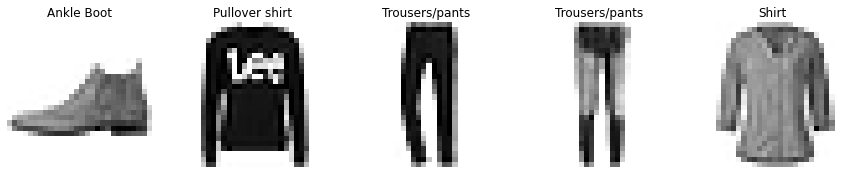

In [6]:
n_examples = 1000
example_images = X_test[0:n_examples]
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15,4))
for j in range(len(axs)):
  axs[j].imshow(example_images[j], cmap='binary')
  axs[j].axis('off')
  axs[j].set_title(class_names[example_labels[j]])

In [7]:
# define encoder
encoded_dim = 2

encoder = Sequential([
                      Flatten(input_shape=(28,28)),
                      Dense(256, activation='sigmoid'),
                      Dense(64, activation='sigmoid'),
                      Dense(encoded_dim)
])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Encoding Dimension 2')

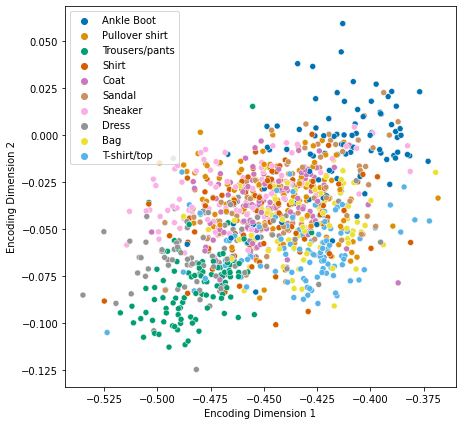

In [8]:
pretrain_example_encodings = encoder(example_images).numpy()

f, ax = plt.subplots(1, 1, figsize=(7,7))
sns.scatterplot(pretrain_example_encodings[:, 0],
                pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=ax,
                palette=sns.color_palette('colorblind', 10))
ax.set_xlabel('Encoding Dimension 1')
ax.set_ylabel('Encoding Dimension 2')

In [9]:
# define decoder
decoder = Sequential([
                      Dense(64, activation='sigmoid', input_shape=(encoded_dim,)),
                      Dense(256, activation='sigmoid'),
                      Dense(28*28, activation='sigmoid'),
                      tf.keras.layers.Reshape((28,28))
])

In [10]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

# specify loss as reconstruction error which is binary_crossentropy since pixels are on scale of [0,1] and can be interpreted as probs
autoencoder.compile(loss='binary_crossentropy')

autoencoder.fit(X_train, X_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3995
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3414
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3336
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3290
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3262
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3246
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3231
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3219
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3209
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3200


In [11]:
posttrain_example_encodings = encoder(example_images).numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


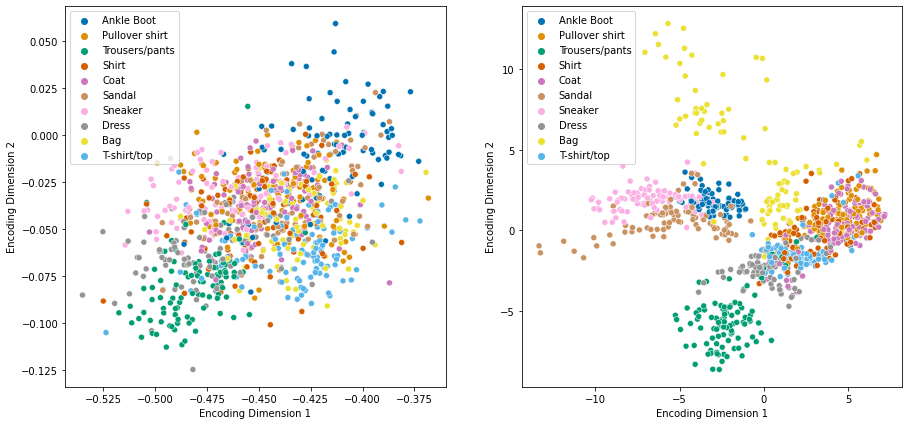

In [12]:
f, axs = plt.subplots(1, 2, figsize=(15,7))

sns.scatterplot(pretrain_example_encodings[:, 0],
                pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[0],
                palette=sns.color_palette('colorblind', 10))
sns.scatterplot(posttrain_example_encodings[:, 0],
                posttrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[1],
                palette=sns.color_palette('colorblind', 10))
for ax in axs:
    ax.set_xlabel('Encoding Dimension 1')
    ax.set_ylabel('Encoding Dimension 2')

In [13]:
reconstructed_example_images = autoencoder(example_images)

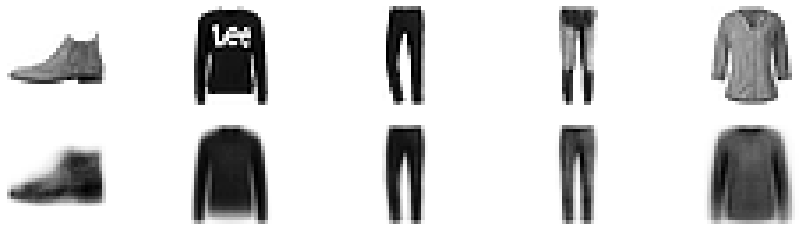

In [14]:
f, axs = plt.subplots(2, 5, figsize=(15,4))
for j in range(5):
  axs[0, j].imshow(example_images[j], cmap='binary')
  axs[1, j].imshow(reconstructed_example_images[j].numpy().squeeze(), cmap='binary')
  axs[0, j].axis('off')
  axs[1, j].axis('off')

## KL divergence
- measure of dissimilarity between distributions
$$
D_{KL} = E_{X_\sim q} \big [log \, q(X) - log \, p(X) \big ]
$$
- smaller score indicates greater degree agreement


In [15]:
q = tfd.Normal(loc=0, scale=1)
p = tfd.Normal(loc=0, scale=0.5)
tfd.kl_divergence(q,p)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8068528>

In [16]:
# use Monte Carlo esimation when there is not a closed form expression for KL divergence
exact_KL_div = tfd.kl_divergence(q,p)
exact_KL_div

<tf.Tensor: shape=(), dtype=float32, numpy=0.8068528>

In [17]:
def MC_estimate_of_KL_div(n, q_sampler, q_density, p_density):
  """
  Computes MC estimate of KL_div using n samples from q_sampler

  q_sampler is function that receives positive integer and returns as many samples from q
  """
  x = q_sampler(n)
  KL_estimate = np.mean(np.log(q_density(x)) - np.log(p_density(x)))
  return KL_estimate

In [18]:
# single MC estimate
n = 1000
q_sampler = q.sample
q_density = q.prob
p_density = p.prob
MC_estimate_of_KL_div(n, q_sampler, q_density, p_density)

0.90587676

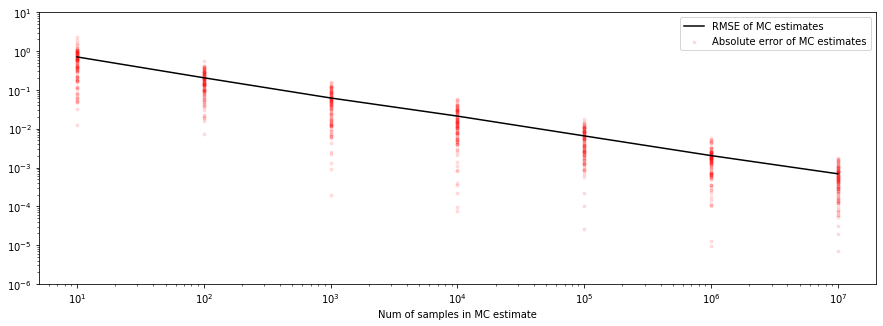

In [19]:
n_grid = 10**np.arange(1,8)
samples_per_grid_point = 100
kl_estimates = np.zeros(shape=[samples_per_grid_point, len(n_grid), 2])

for sample_num in range(samples_per_grid_point):
  for grid_num, n in enumerate(n_grid):
    kl_estimates[sample_num, grid_num, 0] = n
    kl_estimates[sample_num, grid_num, 1] = MC_estimate_of_KL_div(n, q_sampler, q_density, p_density)

abs_error_of_kl_estimates = abs(kl_estimates[..., 1].flatten() - exact_KL_div)
rmse_of_kl_estimates = np.sqrt(np.mean((kl_estimates[...,1] - exact_KL_div)**2, axis=0))

_, ax = plt.subplots(1, 1, figsize=(15,5))
plt.xlabel('Num of samples in MC estimate')
ax.scatter(kl_estimates[...,0],
           abs_error_of_kl_estimates,
           marker='.', color='red',
           alpha=0.1, label='Absolute error of MC estimates')
ax.plot(n_grid, rmse_of_kl_estimates, color='k', label='RMSE of MC estimates')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-6, 10])
ax.legend()
# error goes down as you increase number of samples used to estimate KL_div

## Minimizing KL divergence
- For variational autoencoders, we want to maximize ELBO, which is the sum of two terms:
  - expected reconstruction loss
  - KL divergence from prior distribution to the posterior
- Can think of KL diverence as the expectation over the distribution q of the difference between log q and log p
- always non-negative and only equal to 0 when q=p
- not symmetric KL (q || p) is not equal to KL (p || q)


In [20]:
# define distributions to measure KL divergence
scale_tril = tfb.FillScaleTriL()([-0.5, 1.25, 1.]) # bijector that computes 2x2 lower triangular matrix 
# need to pass in vector with length equal to number of elements in the lower triangular matrix
# 2x2 has 3 elements, 3x3 has 6, etc.
# good way to initialize some random covariance matrix
p = tfd.MultivariateNormalTriL(loc=0., scale_tril=scale_tril)
q = tfd.MultivariateNormalDiag(loc=[0., 0.])
tfd.kl_divergence(q,p)

<tf.Tensor: shape=(), dtype=float32, numpy=3.056092>

In [21]:
scale_tril = tfb.FillScaleTriL()([-0.5, 1.25, 1.])
p = tfd.MultivariateNormalTriL(loc=0., scale_tril=scale_tril) # target density we are trying to approximate

# create trainable distribution to learn p
q = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])),
                               scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]), bijector=tfb.Exp()))
# need to make sure that scale_diag is positive so need to use TransformedVariable class
# use Exp bijector to transform the random variables into values that are always positive

@tf.function
def loss_and_grads(q_dist):
  with tf.GradientTape() as tape:
    loss = tfd.kl_divergence(q_dist, p)
  return loss, tape.gradient(loss, q_dist.trainable_variables)

opt = tf.keras.optimizers.Adam()
num_train_steps = 500
#for i in range(num_train_steps):
#  loss, grads = loss_and_grads(q)
#  opt.apply_gradients(zip(grads, q.trainable_variables))

# note that q can't perfectly fit p since p has a full covariance matrix and q has only a diagonal covariance matrix

In [22]:
tf.random.set_seed(41)

p_mu = [0., 0.]
p_L = tfb.Chain([tfb.TransformDiagonal(tfb.Softplus()),
                 tfb.FillTriangular()])(tf.random.uniform([3])) # this is basically what tfb.FillScaleTriL is doing under the hood
p = tfd.MultivariateNormalTriL(loc=p_mu, scale_tril=p_L)

Text(0, 0.5, '$x_2$')

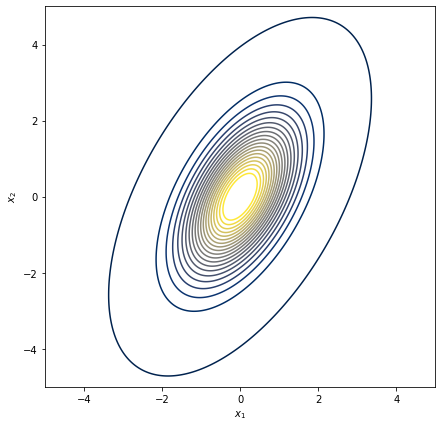

In [23]:
# plot density contours
def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
  X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
  density_values = np.reshape(density(X).numpy(), newshape=X1.shape)

  if ax == None:
    _, ax = plt.subplots(figsize=(7,7))
  
  ax.contour(X1, X2, density_values, **contour_kwargs)
  return(ax)

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
f, ax = plt.subplots(figsize=(7,7))

contour_levels = np.linspace(1e-4, 10**(-0.8), 20)
ax = plot_density_contours(p.prob, X1, X2, {'levels': contour_levels, 'cmap': 'cividis'}, ax=ax)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

In [24]:
tf.random.set_seed(41)

q = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])), 
                               scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]), tfb.Exp()))

In [25]:
@tf.function
def loss_and_grads(dist_a, dist_b):
  with tf.GradientTape() as tape:
    loss = tfd.kl_divergence(dist_a, dist_b)
  return loss, tape.gradient(loss, dist_a.trainable_variables)

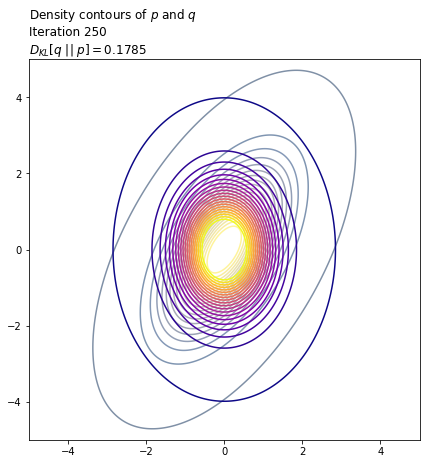

In [33]:
from IPython.display import clear_output
num_train_steps = 250
opt = tf.keras.optimizers.Adam(0.01)
for i in range(num_train_steps):
  q_loss, grads = loss_and_grads(q, p)
  opt.apply_gradients(zip(grads, q.trainable_variables))

  # plot updated density
  if ((i+1) % 10 == 0):
    clear_output(wait=True)
    ax = plot_density_contours(p.prob, X1, X2, {'levels': contour_levels, 'cmap': 'cividis', 'alpha':0.5})
    ax = plot_density_contours(q.prob, X1, X2, {'levels': contour_levels, 'cmap': 'plasma'}, ax=ax)
    ax.set_title('Density contours of $p$ and $q$\n' +
                 'Iteration ' + str(i+1) + '\n' +
                 '$D_{KL}[q \ || \ p] = ' +
                 str(np.round(q_loss.numpy(), 4)) + '$', 
                 loc='left')
    plt.pause(0.01)

q cannot match p since it has a diagonal covariance matrix while p has a full covariance matrix. The most disastrous consequence is that q underestimates the variance along the major axis of p's ellipse

In [52]:
# repeat except this time swap terms in the KL_divergence
tf.random.set_seed(41)

q_rev = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])), 
                               scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]), tfb.Exp()))

In [53]:
@tf.function
def loss_and_grads(dist_a, dist_b, reverse=False):
  with tf.GradientTape() as tape:
    if reverse:
      loss = tfd.kl_divergence(dist_b, dist_a) # swapped
    else:
      loss = tfd.kl_divergence(dist_a, dist_b)
  return loss, tape.gradient(loss, dist_a.trainable_variables)

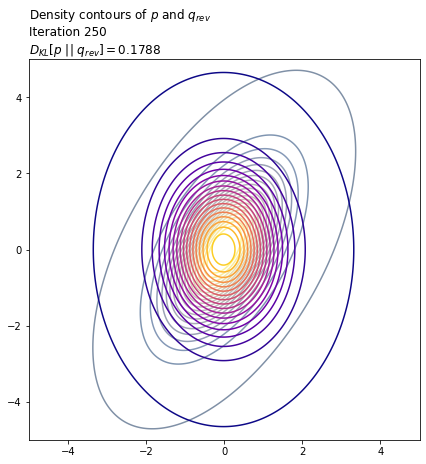

In [54]:
opt = tf.keras.optimizers.Adam(0.01)
for i in range(num_train_steps):
  q_loss, grads = loss_and_grads(q_rev, p, reverse=True)
  opt.apply_gradients(zip(grads, q_rev.trainable_variables))

  # plot updated density
  if ((i+1) % 10 == 0):
    clear_output(wait=True)
    ax = plot_density_contours(p.prob, X1, X2, {'levels': contour_levels, 'cmap': 'cividis', 'alpha':0.5})
    ax = plot_density_contours(q_rev.prob, X1, X2, {'levels': contour_levels, 'cmap': 'plasma'}, ax=ax)
    ax.set_title('Density contours of $p$ and $q_{rev}$\n' +
                 'Iteration ' + str(i+1) + '\n' +
                 '$D_{KL}[p \ || \ q_{rev}] = ' +
                 str(np.round(q_loss.numpy(), 4)) + '$', 
                 loc='left')
    plt.pause(0.01)

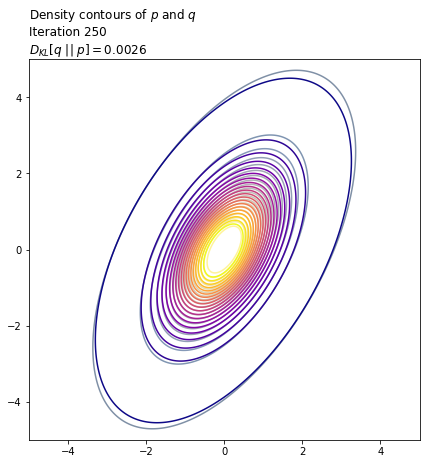

In [55]:
# now fit using q with a full covariance matrix
tf.random.set_seed(41)

q_sigma_init = tfb.FillScaleTriL()(tf.random.normal([3]))

q = tfd.MultivariateNormalTriL(loc=tf.Variable(tf.random.normal([2])),
                                scale_tril=tfp.util.TransformedVariable(q_sigma_init, tfb.FillScaleTriL()))
# use FillScaleTriL to constrain scale_tril to be lower triangluar

opt = tf.keras.optimizers.Adam(0.01)
for i in range(num_train_steps):
  q_loss, grads = loss_and_grads(q, p, reverse=False)
  opt.apply_gradients(zip(grads, q.trainable_variables))

  # plot updated density
  if ((i+1) % 10 == 0):
    clear_output(wait=True)
    ax = plot_density_contours(p.prob, X1, X2, {'levels': contour_levels, 'cmap': 'cividis', 'alpha':0.5})
    ax = plot_density_contours(q.prob, X1, X2, {'levels': contour_levels, 'cmap': 'plasma'}, ax=ax)
    ax.set_title('Density contours of $p$ and $q$\n' +
                 'Iteration ' + str(i+1) + '\n' +
                 '$D_{KL}[q \ || \ p] = ' +
                 str(np.round(q_loss.numpy(), 4)) + '$', 
                 loc='left')
    plt.pause(0.01)

## Maximizing the ELBO of VAEs

In [2]:
latent_size = 2
event_shape = (28, 28, 1)

encoder = Sequential([
                      Conv2D(8, 5, strides=2, activation='tanh', input_shape=event_shape),
                      Conv2D(8, 5, strides=2, activation='tanh'),
                      Flatten(),
                      Dense(64, activation='tanh'),
                      Dense(2*latent_size),
                      tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t[..., :latent_size],
                                                                                   scale_diag=tf.math.exp(t[..., latent_size:])))
], name='encoder')

decoder = Sequential([
                      Dense(64, activation='tanh', input_shape=(latent_size,)),
                      Dense(128, activation='tanh'),
                      tf.keras.layers.Reshape((4,4,8)),
                      tf.keras.layers.Conv2DTranspose(8, 5, strides=2, output_padding=1, activation='tanh'),
                      tf.keras.layers.Conv2DTranspose(8, 5, strides=2, output_padding=1, activation='tanh'),
                      Conv2D(1, 3, padding='same'),
                      Flatten(),
                      tfpl.IndependentBernoulli(event_shape) # assuming binary input data
], name='decoder')

# z ~ N(0, I) = p(z) --> prior
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))
# p(x | z) = decoder(z)
# x ~ p(x | z)
# encoder(x) = q(z | x) ~ p(z | x) --> approximate posterior

def loss_fn(x_true, approx_posterior, x_pred, prior_dist):
  """
  approx_posterior is output of encoder, which is distribution object
  x_pred is output of decoder
  return mean loss of batch
  could also use MC approximation (see above)
  """
  return tf.reduce_mean(tfd.kl_divergence(approx_posterior, prior_dist) - x_pred.log_prob(x_true)) # minimize negative of ELBO

In [3]:
@tf.function
def get_loss_and_grads(x):
  with tf.GradientTape() as tape:
    approx_posterior = encoder(x)
    approx_posterior_sample = approx_posterior.sample()
    x_pred = decoder(approx_posterior_sample)
    current_loss = loss_fn(x, approx_posterior, x_pred, prior)
  grads = tape.gradient(current_loss, encoder.trainable_variables + decoder.trainable_variables)
  return current_loss, grads

The generative model above (once trained) can be used to generate plausible data by sampling a latent variable z from the prior distribution and passing it through the decoder to get the plausible data. You can also encode data into the 'latent space.'

In [4]:
#z = prior.sample(1) # need the 1 to get the batch dim --> (1,2)
#z = decoder(z).sample() # this generates plausible data

## Review of terminology
- $p(z)$ = prior
- $q(z|x)$ = encoding distribution
- $p(x|z)$ = decoding distribution
- maximize ELBO:

$$
log \ p(x) \geq -KL \big [ q(z|x) \ || \ p(z) \big ] + E_{z \sim q(z|x)} \big [ log \ p(x|z) \big ]
$$

- first time will be computed analytically but second term is calculated via sampling a single value from prior that is passed through the decoder

In [8]:
(X_train, _), (X_test, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') /255.
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
example_X = X_test[:16]

In [9]:
batch_size = 64
X_train = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)

In [12]:
encoder(example_X) # get a batch of 16 and event 2 since we specified there to be 2 latent variables

<tfp.distributions.MultivariateNormalDiag 'encoder_distribution_lambda_MultivariateNormalDiag' batch_shape=[16] event_shape=[2] dtype=float32>

In [13]:
decoder(tf.random.normal([16, latent_size])) # batch 16 and event shape (28, 28, 1) which is shape of original images

<tfp.distributions.Independent 'decoder_independent_bernoulli_IndependentBernoulli_Independentdecoder_independent_bernoulli_IndependentBernoulli_Bernoulli' batch_shape=[16] event_shape=[28, 28, 1] dtype=float32>

In [14]:
num_epochs = 5
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
  for train_batch in X_train:
    current_loss, grads = get_loss_and_grads(train_batch)
    opt.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
  print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy()))

-ELBO after epoch 1: 315
-ELBO after epoch 2: 306
-ELBO after epoch 3: 301
-ELBO after epoch 4: 297
-ELBO after epoch 5: 295


In [15]:
def vae(inputs):
  approx_posterior = encoder(inputs)
  decoding_dist = decoder(approx_posterior.sample())
  return decoding_dist.sample()

example_reconstruction = vae(example_X).numpy().squeeze()

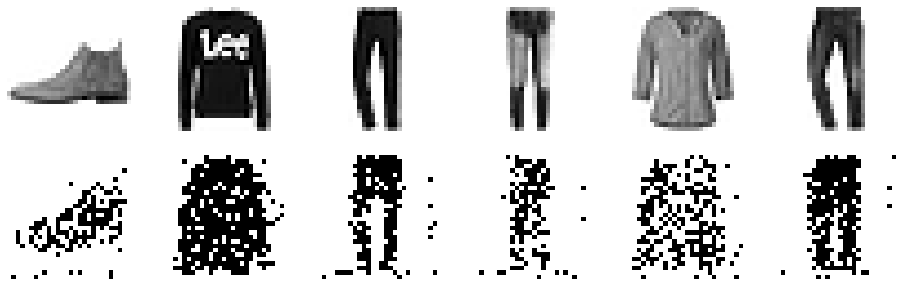

In [16]:
f, axs = plt.subplots(2, 6, figsize=(16,5))
for j in range(6):
  axs[0, j].imshow(example_X[j, :, :].squeeze(), cmap='binary')
  axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
  axs[0, j].axis('off')
  axs[1, j].axis('off')
# doesnt do a good job since it assumes binary pixel values

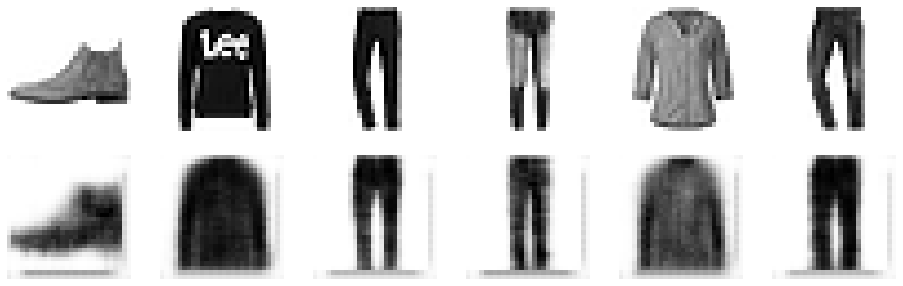

In [17]:
def vae(inputs):
  approx_posterior = encoder(inputs)
  decoding_dist = decoder(approx_posterior.sample())
  return decoding_dist.mean() # change from sample to mean

example_reconstruction = vae(example_X).numpy().squeeze()
f, axs = plt.subplots(2, 6, figsize=(16,5))
for j in range(6):
  axs[0, j].imshow(example_X[j, :, :].squeeze(), cmap='binary')
  axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
  axs[0, j].axis('off')
  axs[1, j].axis('off')
# does better when you use mean of decoding_dist rather than a sample

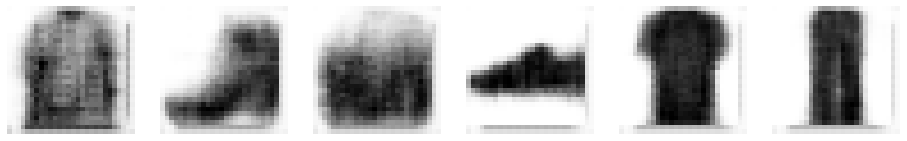

In [22]:
# generate an example
z = prior.sample(6)
generated_x = decoder(z).mean()

f, axs = plt.subplots(1, 6, figsize=(16,5))
for j in range(6):
  axs[j].imshow(generated_x[j,:,:].numpy().squeeze(), cmap='binary')
  axs[j].axis('off')

## KL divergence layers

In [4]:
latent_size = 4
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

encoder = Sequential([
                      Dense(64, activation='relu', input_shape=(12,)),
                      Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)), # remember no activation function before distribution
                      tfpl.MultivariateNormalTriL(latent_size), # posterior distribution approximation
                      tfpl.KLDivergenceAddLoss(prior) # doesn't affect input, must have distribution layer before it, adds KL div to loss
])

decoder = Sequential([
                      Dense(64, activation='relu', input_shape=(latent_size,)),
                      Dense(tfpl.IndependentNormal.params_size(12)),
                      tfpl.IndependentNormal(12)
])
vae = Model(inputs=encoder.input, outputs=decoder(encoder.output))

vae.compile(loss=lambda x, pred: -pred.log_prob(x)) # no longer need KL div term since we added it with layer in encoder model

In [6]:
encoder = Sequential([
                      Dense(64, activation='relu', input_shape=(12,)),
                      Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)), 
                      tfpl.MultivariateNormalTriL(latent_size), 
                      tfpl.KLDivergenceAddLoss(prior, weight=10, use_exact_kl=False,
                                               test_points_fn=lambda q: q.sample(10),
                                               test_points_reduce_axis=0) 
])
# use weights kwarg to weight KL div relative to reconstruction loss
# use_exact_kl=False will use MC estimate rather than analytical solution
# this requires the distribution to be converted to tensor (usually using sampling)
# this can be done be default or overriden with test_points_fn which will specify how we get tensor from distribution
# in this case, we are calculating MC estimate by taking 10 samples from posterior distribution
# reduce estimate to scalar by specifying test_points_reduce_axis=0 which will take sum over batch

In [3]:
(X_train, _), (X_test, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 256. + 0.5/256
X_test = X_test.astype('float32') /256. + 0.5/256
example_X = X_test[:16]

batch_size = 32
X_train = tf.data.Dataset.from_tensor_slices((X_train, X_train)).batch(batch_size)
X_test = tf.data.Dataset.from_tensor_slices((X_test, X_test)).batch(batch_size)

In [4]:
latent_size = 4
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

event_shape = (28, 28)

encoder = Sequential([
                      Flatten(input_shape=event_shape),
                      Dense(128, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(32, activation='relu'),
                      Dense(16, activation='relu'),
                      Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
                      tfpl.MultivariateNormalTriL(latent_size),
                      tfpl.KLDivergenceAddLoss(prior) # estimates KL[ q(z|x) || p(z)]
])
# samples z_j from q(z|x_j)
# then computes log q(z_j|x_j) - log p(z_j) --> mean is added to model loss

In [5]:
encoder.losses # no losses

[<tf.Tensor 'kl_divergence_add_loss/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

In [6]:
encoder(example_X)

<tfp.distributions.MultivariateNormalTriL 'sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[16] event_shape=[4] dtype=float32>

In [7]:
encoder.losses # after passing examples, the KL div loss appears --> this stores the loss of the most recent batch

[<tf.Tensor: shape=(), dtype=float32, numpy=0.8562038>]

In [8]:
encoder = Sequential([
                      Flatten(input_shape=event_shape),
                      Dense(128, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(32, activation='relu'),
                      Dense(16, activation='relu'),
                      Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
                      tfpl.MultivariateNormalTriL(latent_size),
                      tfpl.KLDivergenceAddLoss(prior,
                                               use_exact_kl=False,
                                               weight=1.5,
                                               test_points_fn=lambda q: q.sample(10))
])
# Using these arguments gets shape: (n_samples, batch_size, latent_size)
# KL div calculation becomes (n_samples, batch_size)
# test_points_fn=0 will average over n_samples
# KL div scalar is determined by averaging over remaining dims (batch_size) (basically just averaging over all dims)

In [9]:
decoder = Sequential([
                      Dense(16, activation='relu', input_shape=(latent_size,)),
                      Dense(32, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(2*event_shape[0]*event_shape[1], activation='exponential'), # beta params must be non-neg so use exp activation
                      tf.keras.layers.Reshape((event_shape[0], event_shape[1], 2)),
                      tfpl.DistributionLambda(
                          lambda t: tfd.Independent(
                              tfd.Beta(concentration1=t[..., 0],
                                       concentration0=t[..., 1])
                          )
                      )
])

In [10]:
vae = Model(inputs=encoder.input, outputs=decoder(encoder.output))

vae.compile(loss=lambda x, pred: -pred.log_prob(x))

vae.fit(X_train, validation_data=X_test, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 49s 24ms/step - loss: -1669.9565 - val_loss: -2000.9938
Epoch 2/10
1875/1875 [==============================] - 44s 23ms/step - loss: -1981.2307 - val_loss: -2054.6084
Epoch 3/10
1875/1875 [==============================] - 45s 24ms/step - loss: -2062.8867 - val_loss: -2133.9067
Epoch 4/10
1875/1875 [==============================] - 43s 23ms/step - loss: -2073.7092 - val_loss: -2082.9155
Epoch 5/10
1875/1875 [==============================] - 44s 24ms/step - loss: -2096.8567 - val_loss: -2152.1165
Epoch 6/10
1875/1875 [==============================] - 44s 23ms/step - loss: -2186.7251 - val_loss: -2264.3813
Epoch 7/10
1875/1875 [==============================] - 44s 24ms/step - loss: -2218.4822 - val_loss: -2236.0420
Epoch 8/10
1875/1875 [==============================] - 44s 23ms/step - loss: -2242.1843 - val_loss: -2337.7476
Epoch 9/10
1875/1875 [==============================] - 44s 24ms/step - loss: -2194.2888 - val_loss: -22

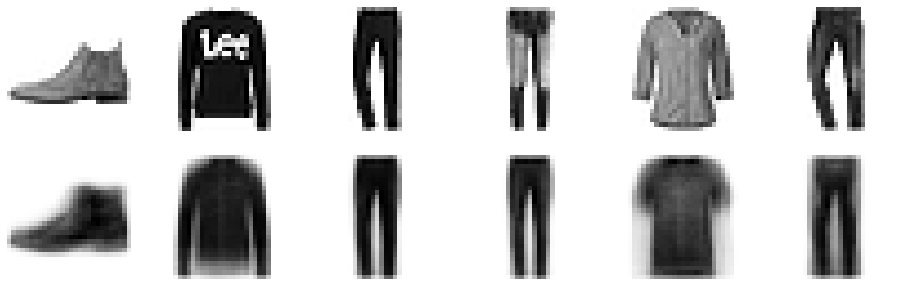

In [11]:
example_reconstruction = vae(example_X).mean().numpy().squeeze()

f, axs = plt.subplots(2, 6, figsize=(16,5))
for j in range(6):
  axs[0, j].imshow(example_X[j, :, :].squeeze(), cmap='binary')
  axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
  axs[0, j].axis('off')
  axs[1, j].axis('off')